### HW2b, Jordan Gittleman

We can continue the previous project as we explained in class by using a feature detector instead of manually picking the points. 

1.	Use a Harris corner or a SIFT feature detector and then match those points using the brute force matcher. How many points would you pick? \
(a)	Use SVD to compute a homography on the overconstrained linear equations that the feature points imply. Remake the mosaic. \
(b)	Now use the cv2.homography with Ransac on the src and dst points after you match the feature points and remake the mosaic. 


In [1]:
import os
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


First lets import the same images as before but at a lower resolution, This allow for better quality points without havbing to use a crazy huge amount.

In [17]:
image_paths=['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg']
images=[]
for image in image_paths:
    img = cv2.imread(image)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (0,0), fx=.1, fy=.1)
    images.append(img)

Next, lets initialize our SIFT feature detector and find some points in two images

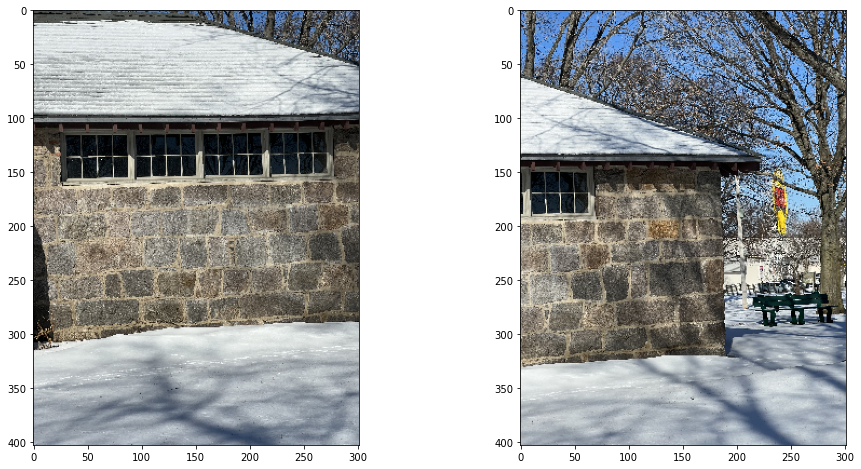

In [20]:
img1 = images[0]
img2 = images[1]
figure, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img2)
ax[1].imshow(img1) 

Here are our images we'll be comparing

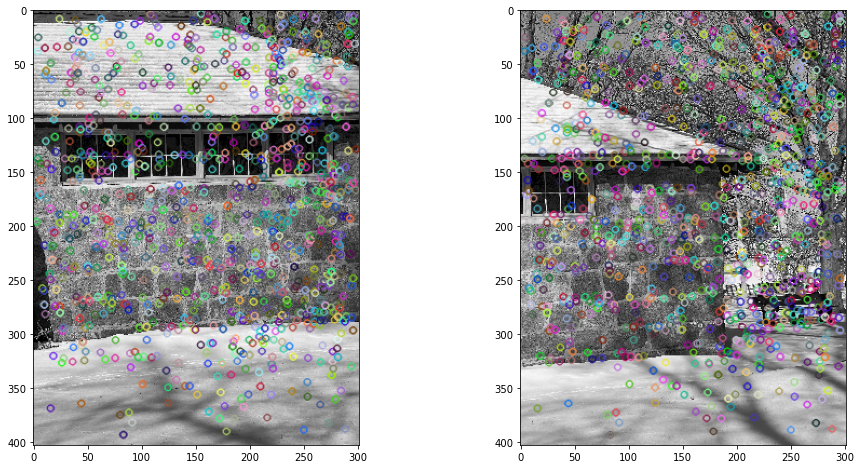

In [25]:

gray1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY) # need to convert to grayscale for SIFT


gray2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY) #

sift = cv2.SIFT_create() #create our detector
keypoints1, descriptors1 = sift.detectAndCompute(img1,None) # detect keypoints and compute descriptors
keypoints2, descriptors2 = sift.detectAndCompute(img2,None) 

img1 = cv2.drawKeypoints(gray1,keypoints1,img1) # draw the points
img2 = cv2.drawKeypoints(gray2,keypoints1,img2)

figure, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img2)
ax[1].imshow(img1)

Based on running sift on these images, we have quite a few detections, lets compare between the two images

Found 265 matches!


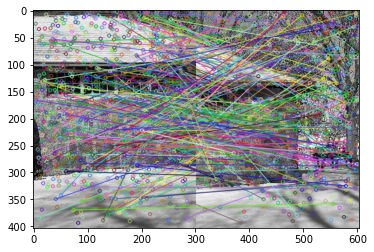

(<matplotlib.image.AxesImage at 0x7f02197993d0>, None)

In [31]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors2,descriptors1)
matches = sorted(matches, key = lambda x:x.distance)
print("Found "+str(len(matches))+" matches!")
img3 = cv2.drawMatches(img2, keypoints2, img1, keypoints1, matches[:], img1, flags=2)
plt.imshow(img3),plt.show()

At the moment, not all of these matches will be good; to see what this stitch would look like from homography we compute from these points, lets build out our SVD code. \
While, we're at it, lets also turn the above sift detector into a function for later.

In [ ]:
def getH(dest_kp, src_kp): # fortunately, I do SVD in part 2a so we just need to import that code
    #and modify for use with keypoints

    dest = np.array([dest_kp[mat.queryIdx].pt for mat in matches])
    src = np.array(src_kp[mat.trainIdx].pt for mat in matches])
    p = np.array([0,0,0,0,0,0,0,0,1])    

    for i in range(len(dest)):
        pi = np.array([[-src[i][0],-src[i][1],-1,0,0,0,src[i][0]*dest[i][0],src[i][1]*dest[i][0],dest[i][0]],
        [0,0,0,-src[i][0],-src[i][1],-1,src[i][0]*dest[i][1],src[i][1]*dest[i][1],dest[i][1]]])
        p = np.vstack((pi,p))

  
    x = np.zeros((len(dest)*2,1))
    x = np.vstack((x,np.array([1])))
    H, residuals, rank, s = np.linalg.lstsq(p,x)
    H = H.reshape((3,3))
    

    return H



(<KeyPoint 0x7f0219d08db0>,
 <KeyPoint 0x7f0219b00630>,
 <KeyPoint 0x7f0219af32d0>,
 <KeyPoint 0x7f0219af3270>,
 <KeyPoint 0x7f0219aa73c0>,
 <KeyPoint 0x7f0219aa73f0>,
 <KeyPoint 0x7f0219aa72d0>,
 <KeyPoint 0x7f0219aa70f0>,
 <KeyPoint 0x7f0219aa7360>,
 <KeyPoint 0x7f0219ab0270>,
 <KeyPoint 0x7f0219ab0ea0>,
 <KeyPoint 0x7f0219c4bcc0>,
 <KeyPoint 0x7f0219c4bc60>,
 <KeyPoint 0x7f0219c4bd80>,
 <KeyPoint 0x7f0219c4bf00>,
 <KeyPoint 0x7f0219a2ff90>,
 <KeyPoint 0x7f0219a2ffc0>,
 <KeyPoint 0x7f0219a2fed0>,
 <KeyPoint 0x7f0219abfed0>,
 <KeyPoint 0x7f0219abff00>,
 <KeyPoint 0x7f0219a352a0>,
 <KeyPoint 0x7f0219a352d0>,
 <KeyPoint 0x7f0219a35e10>,
 <KeyPoint 0x7f0219a35ed0>,
 <KeyPoint 0x7f0219a35d80>,
 <KeyPoint 0x7f0219a35030>,
 <KeyPoint 0x7f0219a35db0>,
 <KeyPoint 0x7f0219a35ea0>,
 <KeyPoint 0x7f0219a35330>,
 <KeyPoint 0x7f0219a35510>,
 <KeyPoint 0x7f0219a35090>,
 <KeyPoint 0x7f0219a35060>,
 <KeyPoint 0x7f0219a11bd0>,
 <KeyPoint 0x7f0219a11c00>,
 <KeyPoint 0x7f0219a11ea0>,
 <KeyPoint 0x7f0219a